# Manage volumetric fluorescent microscopy experiments with DataJoint Elements

This notebook will walk through processing volumetric two-photon calcium imaging
data with the DataJoint Workflow for volumetric image processing. The workflow
currently supports volumetric data collected
from `ScanImage`. 

**Please note that uploading data to BossDB via this pipeline requires the
following:**
+ An API token which can be obtained by creating an account at
[api.bossdb.io](https://api.bossdb.io). You will also need resource manager
permissions from the team at [BossDB](https://bossdb.org).
+ A local setup of the [intern](https://github.com/jhuapl-boss/intern) REST API
  using the instructions below:
    + Create a new folder `.intern` in your root directory.
    + Create a configuration file `intern.cfg` within the `.intern` folder. The
     path to this file should be `~/.intern/intern.cfg`. 
    + The `intern.cfg` file should contain the following exactly as shown below:
      ```bash
      # ~/.intern/intern.cfg
      [Default]
      protocol = https
      host = api.bossdb.io
      token = <your-api-key>
      ```


In this notebook, we will explain the following concepts as they relate to this workflow:
- What is an Element versus a Workflow?
- Plot the workflow with `dj.Diagram`
- Insert data into tables
- Query table contents
- Fetch table contents
- Run the workflow for your experiments

For detailed documentation and tutorials on general DwataJoint principles that support collaboration, automation, reproducibility, and visualizations:

- [DataJoint Interactive Tutorials](https://github.com/datajoint/datajoint-tutorials) - Fundamentals including table tiers, query operations, fetch operations, automated computations with the `make` function, etc.

- [DataJoint Core - Documentation](https://datajoint.com/docs/core/) - Relational data model principles

- [DataJoint API for Python - Documentation](https://datajoint.com/docs/core/datajoint-python/)

- [DataJoint Element for Volumetric Calcium Imaging - Documentation](https://datajoint.com/docs/elements/element-zstack/)

Let's start by importing the packages necessary to run this workflow.

In [2]:
import os

if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")


import datajoint as dj
import datetime

In [3]:
dj.conn()

[2024-04-03 03:44:05,175][INFO]: Connecting root@fakeservices.datajoint.io:3306
[2024-04-03 03:44:05,182][INFO]: Connected root@fakeservices.datajoint.io:3306


DataJoint connection (connected) root@fakeservices.datajoint.io:3306

## The DataJoint Workflow for volumetric Calcium Imaging is assembled from 5 DataJoint Elements

| Element | Source Code | Documentation | Description |
| -- | -- | -- | -- |
| Element Lab | [Link](https://github.com/datajoint/element-lab) | [Link](https://datajoint.com/docs/elements/element-lab) | Lab management related information, such as Lab, User, Project, Protocol, Source. |
| Element Animal | [Link](https://github.com/datajoint/element-animal) | [Link](https://datajoint.com/docs/elements/element-animal) | General animal metadata and surgery information. |
| Element Session | [Link](https://github.com/datajoint/element-session) | [Link](https://datajoint.com/docs/elements/element-session) | General information of experimental sessions. |
| Element Calcium Imaging | [Link](https://github.com/datajoint/element-calcium-imaging) | [Link](https://datajoint.com/docs/elements/element-calcium-imaging) |  General information about the calcium imaging scan. |
| Element zstack | [Link](https://github.com/datajoint/element-zstack) | [Link](https://datajoint.com/docs/elements/element-zstack) |  Volumetric data segmentation and export. |

Each workflow is composed of multiple Elements. Each Element contains 1 or more modules, and each module declares its own schema in the database.

The Elements are imported within the `workflow_zstack.pipeline` script.

By importing the modules for the first time, the schemas and tables will be created in the database.  Once created, importing modules will not create schemas and tables again, but the existing schemas/tables can be accessed.

The schema diagram (shown below) is a good reference for understanding the order of the tables within the workflow.

Let's activate the Elements.

In [4]:
from tutorial_pipeline import (
    lab,
    subject,
    session,
    scan,
    volume,
    bossdb,
)

[2024-04-03 03:44:15,821][WARNING]: lab.Project and related tables will be removed in a future version of Element Lab. Please use the project schema.


## Diagram

We can plot the diagram of tables within multiple schemas and their dependencies using `dj.Diagram()`.  For details, see the [documentation](https://datajoint.com/docs/core/concepts/getting-started/diagrams/).

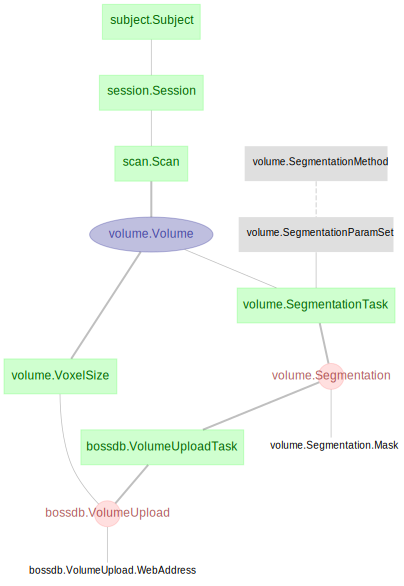

In [5]:
(
    dj.Diagram(subject.Subject)
    + dj.Diagram(session.Session)
    + dj.Diagram(scan.Scan)
    + dj.Diagram(volume)
    + dj.Diagram(bossdb)
)

While the diagram above seems complex at first, it becomes more clear when it's approached as a hierarchy of tables that define the order in which the workflow expects to receive data in each of its tables.

The tables higher up in the diagram such as `subject.Subject()` should be the first to receive data.

Data is manually entered into the green, rectangular tables with the `insert1()` method.

Tables connected by a solid line depend on entries from the table above it.

There are 5 table tiers in DataJoint. Some of these tables appear in the diagram above.

| Table tier | Color and shape | Description |
| -- | -- | -- |
| Manual table | Green box | Data entered from outside the pipeline, either by hand or with external helper scripts. |
| Lookup table | Gray box | Small tables containing general facts and settings of the data pipeline; not specific to any experiment or dataset. |  
| Imported table | Blue oval | Data ingested automatically inside the pipeline but requiring access to data outside the pipeline. |
| Computed table | Red circle | Data computed automatically entirely inside the pipeline. |
| Part table | Plain text | Part tables share the same tier as their master table. |

## Insert entries into manual tables

In this section, we will insert metadata about an animal subject, experiment session, and optogenetic stimulation parameters.

Let's start with the first schema and table in the schema diagram (i.e. `subject.Subject` table).

Each module (e.g. `subject`) contains a schema object that enables interaction with the schema in the database.

In [ ]:
subject.schema

The table classes in the module correspond to a table in the database.

In [ ]:
subject.Subject()

We can view the table dependencies and the attributes we need to insert by using the functions `.describe()` and `.heading`.  The `describe()` function displays the table definition with foreign key references and the `heading` function displays the attributes of the table definition.  These are particularly useful functions if you are new to DataJoint Elements and are unsure of the attributes required for each table.

In [ ]:
print(subject.Subject.describe())

In [ ]:
subject.Subject.heading

We will insert data into the `subject.Subject` table. 

In [ ]:
subject.Subject.insert1(
    dict(
        subject="subject1",
        sex="M",
        subject_birth_date="2023-01-01",
        subject_description="Cellpose segmentation of volumetric data.",
    )
)
subject.Subject()

Let's continue inserting in the other manual tables. The `Session` table is next.

In [ ]:
print(session.Session.describe())

In [ ]:
session.Session.heading

The cells above show the dependencies and attributes for the `session.Session` table.

Notice that `describe` shows the dependencies of the table on upstream tables (i.e. foreign key references). The `Session` table depends on the upstream `Subject` table. 

Whereas `heading` lists all the attributes of the `Session` table, regardless of
whether they are declared in an upstream table.

In [ ]:
session_key = dict(
    subject="subject1",
    session_id=0,
)
session.Session.insert1(
    dict(
        session_key,
        session_datetime=datetime.datetime.now(),
    ),
)
session.Session()

The `SessionDirectory` table locates the relevant data files in a directory path
relative to the root directory defined in your `dj.config["custom"]`. More
information about `dj.config` is provided at the end of this tutorial and is
particularly useful for local deployments of this workflow.

In [ ]:
print(session.SessionDirectory.describe())

In [ ]:
session.SessionDirectory.heading

In [ ]:
session.SessionDirectory.insert1(
    dict(session_key, session_dir="subject1/session1"),
    skip_duplicates=True,
)
session.SessionDirectory()

Each volume requires an entry in the `Scan` table from
`element-calcium-imaging`. Here, we'll use `describe` and `heading` for the Scan
table and insert an entry for the current session.

In [ ]:
print(scan.Scan.describe())

In [ ]:
scan.Scan.heading

In [ ]:
scan.Scan.insert1(
    dict(
        session_key,
        scan_id=0,
        acq_software="ScanImage",
    ),
    skip_duplicates=True,
)
scan_key = (scan.Scan & "subject = 'subject1'").fetch1("KEY")

## Populate

### Automatically populate tables

`volume.Volume` is the first table in the pipeline that can be populated automatically.
If a table contains a part table, this part table is also populated during the
`populate()` call. `populate()` takes several arguments including a session
key. This key restricts `populate()` to performing the operation on the session
of interest rather than all possible sessions which could be a time-intensive
process for databases with lots of entries.

Let's view the `volume.Volume` and populate it using the `populate()` call.

In [ ]:
volume.Volume.heading

In [ ]:
volume.Volume()

In [ ]:
volume.Volume.populate(scan_key, display_progress=True)

Let's view the information was entered into this table:

In [ ]:
volume.Volume()

We're almost ready to perform volume segmentation with `cellpose`. An important step before
processing is managing the parameters which will be used in that step. To do so, we will
insert parameters required by cellpose into a DataJoint table
`SegmentationParamSet`. This table keeps track of all combinations of your image
processing parameters. You can choose which parameters are used during
processing in a later step.

Let's view the attributes and insert data into `volume.SegmentationParamSet`.

In [ ]:
volume.SegmentationParamSet.heading

In [ ]:
volume.SegmentationParamSet.insert_new_params(
    segmentation_method="cellpose",
    paramset_idx=1,
    params=dict(
        diameter=None,
        min_size=2,
        do_3d=False,
        anisotropy=0.5,
        model_type="nuclei",
        channels=[[0, 0]],
        z_axis=0,
        skip_duplicates=True,
    ),
)

DataJoint uses a `SegmentationTask` table to
manage which `Volume` and `SegmentationParamSet` should be used during processing. 

This table is important for defining several important aspects of
downstream processing. Let's view the attributes to get a better understanding. 

In [ ]:
print(volume.SegmentationTask.describe())

In [ ]:
volume.SegmentationTask.heading

The `SegmentationTask` table contains two important attributes: 
+ `paramset_idx`
+ `task_mode`

The `paramset_idx` attribute is tracks
your segmentation parameter sets. You can choose the parameter set on which
you want to run segmentation analysis based on this attribute. This
attribute tells the `Segmentation` table which set of parameters you are
processing in a given `populate()`.

The `task_mode` attribute can be set to either `load` or `trigger`. When set to `trigger`, the
segmentation step will run cellpose on the raw data.

In [ ]:
volume.SegmentationTask.insert1(
    dict(
        scan_key,
        paramset_idx=1,
        task_mode="trigger",
    ),
)

For now, Element ZStack only supports triggering cellpose. Now, we can popluate
the `Segmentation` table. This step may take several hours, depending on your
computer's capabilities.

In [ ]:
volume.Segmentation.populate(scan_key, display_progress=True)

Volumetric data uploaded to BossDB requires information about voxel size. The
DataJoint table `volume.VoxelSize` can be used to insert this information for a
given dataset.

In [ ]:
volume.VoxelSize.heading

In [ ]:
volume.VoxelSize.insert1(dict(scan_key, width=0.001, height=0.001, depth=0.001))

Let's define an `upload_key` to automatically upload the volume to BossDB via the
`bossdb` schema. The `upload_key` combines information about the current scan from
`scan.Scan` and the `paramset_idx` from `SegmentationParamSet`.

In [ ]:
upload_key = dict(scan_key, paramset_idx=1)

The first table in this schema is `VolumeUploadTask`. Let's define the upload task by naming the collection, experiment,
and channel where the data should be uploaded.

In [ ]:
print(bossdb.VolumeUploadTask.describe())

In [ ]:
bossdb.VolumeUploadTask.heading

In [ ]:
collection = "dataJointTestUpload"
experiment = "CalciumImaging"
channel = "volume-image"
bossdb.VolumeUploadTask.insert1(
    dict(
        upload_key,
        collection_name=collection,
        experiment_name=experiment,
        channel_name=channel,
    )
)

Finally, we can upload data. 

As a reminder, uploading data to BossDB via this pipeline requires an API
token which can be obtained by creating an account at
[api.bossdb.io](https://api.bossdb.io). You will also need resource manager
permissions from the team at [BossDB](https://bossdb.org).

In [ ]:
bossdb.VolumeUpload.populate(upload_key)

To visualize the volumetric data, import the neuroglancer URL and paste it into
your browser.

In [ ]:
(bossdb.VolumeUpload.WebAddress & upload_key & "upload_type='image+annotation'").fetch1(
    "web_address"
)